# Top panel: Decoding accuracy comparison (per bird)

In [1]:
# common
import os
import sys
import json
import pickle as pkl
import numpy as np
import warnings
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.ndimage import gaussian_filter, gaussian_filter1d

def add_to_sys_path(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        sys.path.append(dirpath)        
root_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/'
add_to_sys_path(root_dir)

# sklearn
from sklearn.metrics import mean_squared_error

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# ensongdec
from FFNNmodel import FeedforwardNeuralNetwork, ffnn_predict
from neural_audio_dataset import NeuralAudioDataset
import utils.audio_utils as au
import utils.signal_utils as su
import utils.encodec_utils as eu

# songbirdcore
import songbirdcore.spikefinder.spike_analysis_helper as sh
import songbirdcore.spikefinder.filtering_helper as fh
import songbirdcore.utils.label_utils as luts
import songbirdcore.utils.plot_utils as puts
import songbirdcore.utils.audio_spectrogram_utils as auts

# EncoDec
from encodec import EncodecModel
from encodec.utils import convert_audio

# Tim S. noise reduce
import noisereduce as nr

from decoder_testing_functionality import *
from decoder_testing_functionality import get_original_reconstructed_audio
from decoder_testing_functionality import load_model_statedict, load_model_statedict_align_complimentary_space

## Reconstruct spectrogams and compute reconstruction error

spiketrains HVC
Loading model:  THRESHOLDS_z_r12r13_21_20240524_184625_FFNN_20240526_013857.pt
Loading THRESHOLDS_z_r12r13_21_20240524_184625_FFNN_20240526_013857_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [170, 64, 64, 128]
Length of neural trials: 900.0 ms, length of audio trials: 900.0 ms. 
Using 2 bins of neural data history.
Data loaders created. Training samples: 4847, Testing sample: 1330
spiketrains RA
Loading model:  THRESHOLDS_z_r12r13_21_20240524_184625_FFNN_20240526_013857.pt
Loading THRESHOLDS_z_r12r13_21_20240524_184625_FFNN_20240526_013857_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45

(Text(0, 0.5, ''), [])

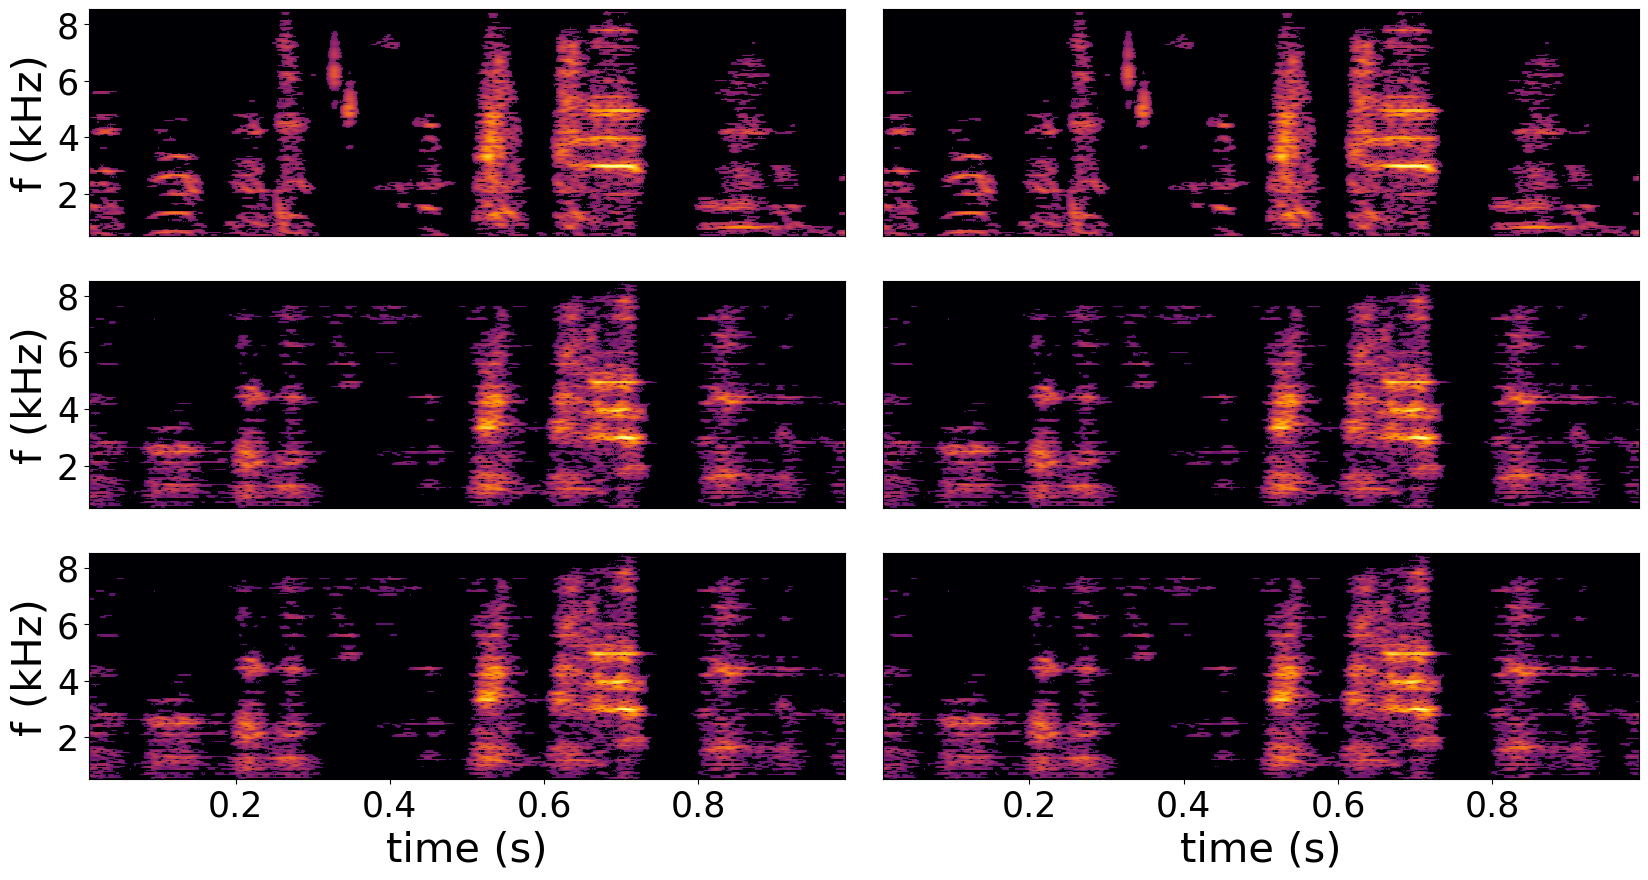

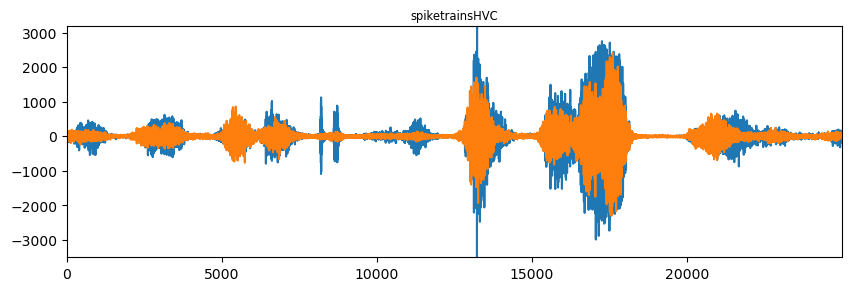

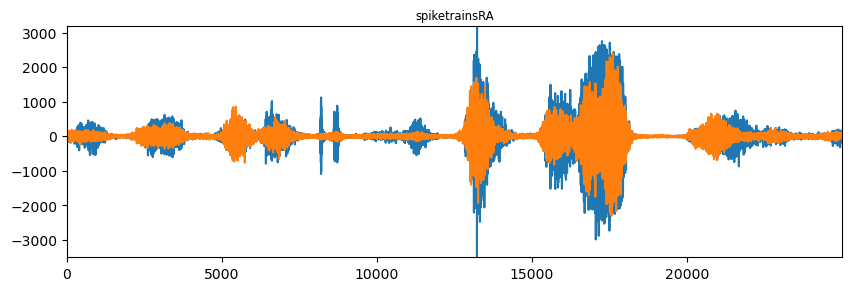

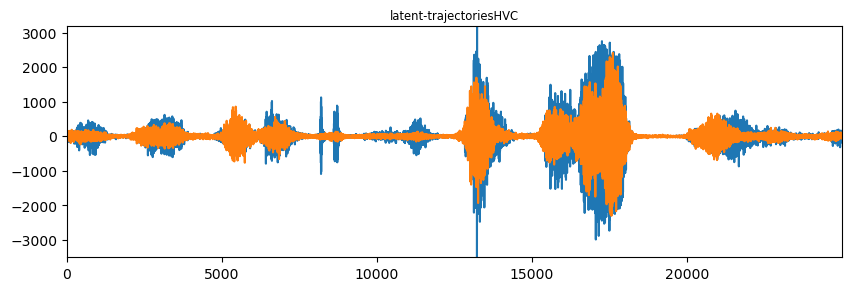

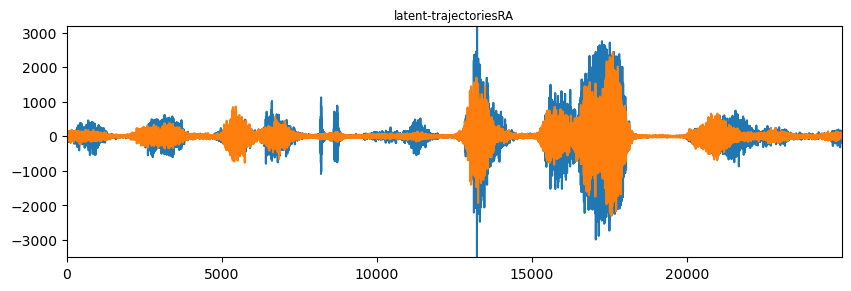

In [3]:
warnings.filterwarnings("ignore")

bird = 'z_w12m7_20'
models_dict = {
    'spiketrains': {
        'HVC': '20240526_013857',
        'RA': '20240526_013857'
    },
    
    'latent-trajectories': {
        'HVC': '20240526_013857',
        'RA': '20240526_013857'
    }
}

# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df1 = pd.DataFrame(columns=column_names)

# Plotting setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05)

# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):
        print(model_type, nucleus)

        # Load model
        model_timestamp = models_dict[model_type][nucleus]
        model_extension = '.pt'  
        model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
        model_filename = next((file for file in model_files if model_timestamp in file), None)

        print('Loading model: ', model_filename)
        ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=False)

        # Reconstruct spectrogram
        scale = torch.mean(scales)
        original_audio, decoded_audio = get_original_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)

        # Calculate spectrogram reconstruction error
        s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
        s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
        spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
        
        decoding_accuracy_df1.loc[len(decoding_accuracy_df1)] = [model_filename, nucleus, model_type, spec_reconstruction_error]

        # Plot original and reconstructed
        plot_s = 1
        plot_samples = int(plot_s*fs_audio)
        
        plt.subplots(nrows=1, figsize=(10, 3))
        plt.title(model_type + nucleus)
        plt.plot(original_audio[:plot_samples])
        plt.plot(decoded_audio[:plot_samples])
        
        xlabel = True if row == 1 else False
        plot_spectrogram(decoded_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)

# Top row: repeat the plot of the original spectrograms in both columns
plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 0], xlabel=False, ylabel=True)
plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 1], xlabel=False, ylabel=False)
axes[1,1].set_ylabel(''), axes[1,1].set_yticks([])
axes[2,1].set_ylabel(''), axes[2,1].set_yticks([])



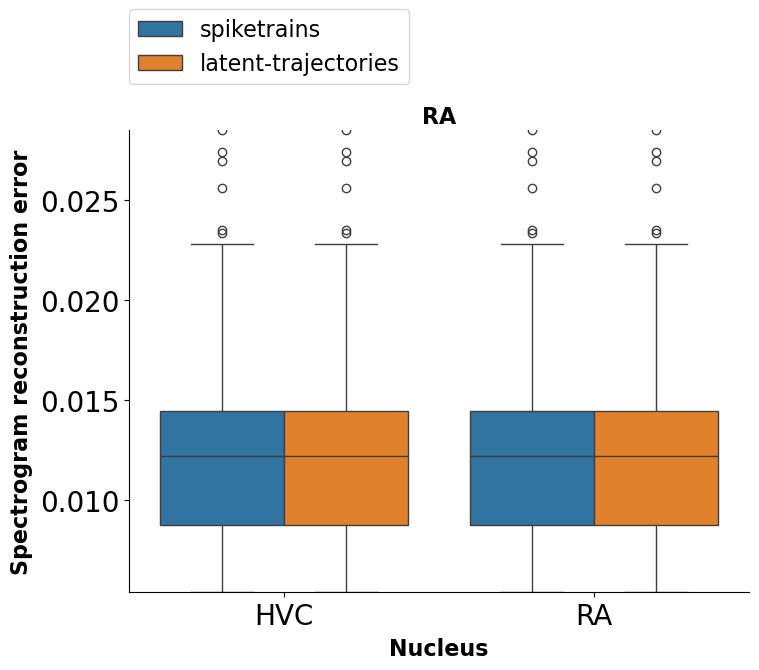

In [4]:
# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df1.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)


plt.title(nucleus, fontsize=16, fontweight='bold')
plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type, fontsize=16, fontweight='bold')

# Remove top and right spines
# ax.set_ylim([0, 0.065])
# ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 

plt.show()